In [ ]:
#import libraries
import numpy as np
import pandas as pd
import kagglehub
from google.colab import drive
import torch
!pip install git+https://github.com/openai/CLIP.git
import clip
from PIL import Image
import torch
from torchvision.datasets import CIFAR100
import cv2
import os
from google.colab import drive
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-01gp7f0s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-01gp7f0s
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
#path = "/content/content/MyDrive/Stanford_Cars/stanford-cars-real-train-fewshot/stanford-cars-real-train-fewshot"
#fakepath = "/content/content/MyDrive/Stanford_Cars/stanford-cars-synthetic-classwise-16/synthetic_16"
path = "content/MyDrive/Colab Notebooks/Datasets/Real_cars"
fakepath = "content/MyDrive/Colab Notebooks/Datasets/synthetic_16"


In [ ]:
#get all filenames in the folder
import os
from google.colab import drive
drive.mount('content')

labels = os.listdir(path)
fakelabels = os.listdir(fakepath)
print(len(fakelabels))
print(labels)
from tqdm import tqdm
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

Drive already mounted at content; to attempt to forcibly remount, call drive.mount("content", force_remount=True).
196
['Acura RL Sedan 2012', 'Acura Integra Type R 2001', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'AM General Hummer SUV 2000', 'Suzuki SX4 Sedan 2012', 'Suzuki SX4 Hatchback 2012', 'Toyota 4Runner SUV 2012', 'Volkswagen Golf Hatchback 2012', 'Toyota Camry Sedan 2012', 'Volkswagen Beetle Hatchback 2012', 'Toyota Sequoia SUV 2012', 'Tesla Model S Sedan 2012', 'Toyota Corolla Sedan 2012', 'Volkswagen Golf Hatchback 1991', 'Volvo C30 Hatchback 2012', 'Volvo 240 Sedan 1993', 'Aston Martin V8 Vantage Coupe 2012', 'Audi A5 Coupe 2012', 'Aston Martin Virage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Audi 100 Wagon 1994', 'Volvo XC90 SUV 2007', 'Audi 100 Sedan 1994', 'Aston Martin V8 Vantage Convertible 2012', 'Audi RS 4 Convertible 2008', 'Audi R8 Coupe 2012', 'Audi TT RS Coupe 2012', 'Audi S6 Sedan 2011', 'Audi

In [ ]:
from tqdm import tqdm
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

def get_image_filepaths(folder):
    """Get a list of image file paths in the given folder."""
    return [
        os.path.join(folder, fname)
        for fname in os.listdir(folder)
        if os.path.isfile(os.path.join(folder, fname))
    ]

def load_images_from_folder(folder, batch_size=16):
    """Load and preprocess images from a folder in batches, handling empty folders."""
    filepaths = get_image_filepaths(folder)

    if not filepaths:  # Check if the folder is empty
        print(f"Warning: Folder '{folder}' is empty. Skipping.")
        return None  # You can return an empty list or None as needed

    all_inputs = []
    num_files = len(filepaths)

    for i in range(0, num_files, batch_size):
        batch_paths = filepaths[i:i+batch_size]
        images = []
        for img_path in batch_paths:
            img = Image.open(img_path).convert('RGB')
            input_tensor = preprocess(img)
            images.append(input_tensor)
        batch = torch.stack(images).to(device)
        all_inputs.append(batch)

    inputs = torch.cat(all_inputs, dim=0)
    return inputs


real_images = []
fake_images = []

labels.pop(0)  # Remove the first label if necessary

for label in tqdm(labels):
    real_folder = os.path.join(path, label)
    fake_folder = os.path.join(fakepath, label)

    if not os.path.exists(real_folder) or not os.path.exists(fake_folder):
        print(f"Warning: Folder(s) not found for label '{label}'. Skipping.")
        continue
    real_inputs = load_images_from_folder(real_folder)
    if real_inputs is not None:  # Only append if folder is not empty
        real_images.append(real_inputs)

    fake_inputs = load_images_from_folder(fake_folder)
    if fake_inputs is not None:  # Only append if folder is not empty
        fake_images.append(fake_inputs)


 95%|█████████▌| 186/195 [28:58<01:24,  9.39s/it]

100%|██████████| 195/195 [30:10<00:00,  9.28s/it]


In [ ]:
# Transform the inputs into tensors
real_image_inputs = torch.cat(real_images)
fake_image_inputs = torch.cat(fake_images)

In [ ]:
#shape of the tensor
print(real_image_inputs.shape)
print(fake_image_inputs.shape)

torch.Size([3104, 3, 224, 224])
torch.Size([3104, 3, 224, 224])


In [ ]:
#fake_image_inputs = torch.load('/content/content/MyDrive/Stanford_Cars/fake_image_inputs.pt')
#real_image_inputs = torch.load('/content/content/MyDrive/Stanford_Cars/real_image_inputs.pt')
#Load the data in batches
real_image_inputs = torch.load('content/MyDrive/Colab Notebooks/Datasets/real_image_inputs.pt')
fake_image_inputs = torch.load('content/MyDrive/Colab Notebooks/Datasets/fake_image_inputs.pt')

<ipython-input-4-3310b93fc16d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  real_image_inputs = torch.load('content/MyDrive/Colab Notebooks/Datasets/real_image_inputs.pt

In [ ]:
#make a subset of the inputs
real_image_inputs_sub = real_image_inputs[:160]
fake_image_inputs_sub = fake_image_inputs[:160]

In [ ]:
fake_image_inputs.shape

torch.Size([3120, 3, 224, 224])

In [ ]:
# Move model to the correct device
model = model.to(device)

# Move inputs to the correct device
real_image_inputs_sub = real_image_inputs.to(device)
fake_image_inputs_sub = fake_image_inputs.to(device)

# Inference
with torch.no_grad():
    # Encode images using the model
    real_image_features = model.encode_image(real_image_inputs)
    fake_image_features = model.encode_image(fake_image_inputs)

NameError: name 'model' is not defined

In [ ]:
# Dictionary to store intermediate outputs
intermediate_outputs = {}

# Function to capture layer outputs
def hook_fn(module, input, output):
    intermediate_outputs["layer"] = output.detach()

def extract_intermediate_features(model, inputs, device="cuda"):
    """Extract and flatten intermediate features from a specified layer."""
    features = []
    model.to(device)
    # Split into batches of size 16
    inputs = torch.split(inputs, 16)
    for batch in inputs:
        batch = batch.to(device)
        with torch.no_grad():
            _ = model.encode_image(batch)  # Use encode_image to process only images
        # Flatten the intermediate layer outputs
        flattened_output = intermediate_outputs["layer"].contiguous().view(intermediate_outputs["layer"].size(0), -1)
        features.append(flattened_output.cpu())
    return torch.cat(features, dim=0)  # Combine all outputs

# Set specific perplexity and layer
perplexity = 5
layer = 5

# Iterate over intervals of 160
interval_size = 160
label = 1
for start in range(0, len(real_image_inputs), interval_size):
    end = start + interval_size
    real_subset = real_image_inputs[start:end]
    fake_subset = fake_image_inputs[start:end]

    # Skip if the subset is empty
    if len(real_subset) == 0 or len(fake_subset) == 0:
        continue

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Register a hook on the specified layer
    target_layer = model.visual.transformer.resblocks[layer]  # Use the specific layer
    hook_handle = target_layer.register_forward_hook(hook_fn)

    # Extract intermediate features for the interval
    real_intermediate_features = extract_intermediate_features(model, real_subset, device=device)
    fake_intermediate_features = extract_intermediate_features(model, fake_subset, device=device)

    # Convert to NumPy for t-SNE
    real_intermediate_features_np = real_intermediate_features.numpy()
    fake_intermediate_features_np = fake_intermediate_features.numpy()

    # Concatenate real and fake features
    intermediate_features_np = np.concatenate([real_intermediate_features_np, fake_intermediate_features_np], axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_features_np)

    # Plot the t-SNE results
    ax.scatter(tsne_results[:len(real_intermediate_features), 0],
               tsne_results[:len(real_intermediate_features), 1], color="blue", label="Real images")
    ax.scatter(tsne_results[len(real_intermediate_features):, 0],
               tsne_results[len(real_intermediate_features):, 1], color="red", label="Synthetic images")

    ax.legend()
    ax.set_title(f"t-SNE of layer {layer + 1}, perplexity {perplexity}, {labels[label]}")
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    # Remove the hook after you're done
    hook_handle.remove()

    # Save the figure for this interval
    fig.savefig(f'content/MyDrive/tSNE-L{layer}-p{perplexity}-{labels[label]}.png')
    label += 1

    plt.close(fig)  # Close the figure to free memory


KeyboardInterrupt: 

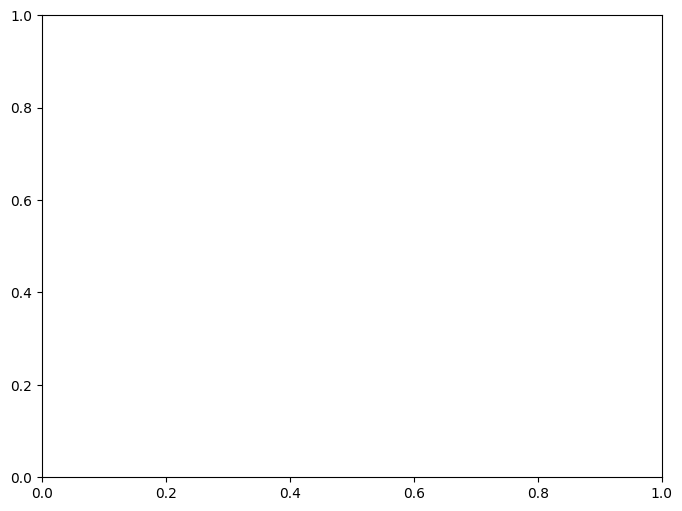

In [ ]:
# Dictionary to store intermediate outputs
intermediate_outputs = {}

# Function to capture layer outputs
def hook_fn(module, input, output):
    intermediate_outputs["layer"] = output.detach()

def extract_intermediate_features(model, inputs, device="cuda"):
    """Extract and flatten intermediate features from a specified layer."""
    features = []
    model.to(device)
    # Split into batches of size 16
    inputs = torch.split(inputs, 16)
    for batch in inputs:
        batch = batch.to(device)
        with torch.no_grad():
            _ = model.encode_image(batch)  # Use encode_image to process only images
        # Flatten the intermediate layer outputs
        flattened_output = intermediate_outputs["layer"].contiguous().view(intermediate_outputs["layer"].size(0), -1)
        features.append(flattened_output.cpu())
    return torch.cat(features, dim=0)  # Combine all outputs

# Set specific perplexity and layer
perplexity = 5
layer = 5

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Register a hook on the specified layer
target_layer = model.visual.transformer.resblocks[layer]  # Use the specific layer
hook_handle = target_layer.register_forward_hook(hook_fn)

# Extract intermediate features
real_intermediate_features = extract_intermediate_features(model, real_image_inputs, device=device)
fake_intermediate_features = extract_intermediate_features(model, fake_image_inputs, device=device)

# Convert to NumPy for t-SNE
real_intermediate_features_np = real_intermediate_features.numpy()
fake_intermediate_features_np = fake_intermediate_features.numpy()

# Concatenate real and fake features
intermediate_features_np = np.concatenate([real_intermediate_features_np, fake_intermediate_features_np], axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
tsne_results = tsne.fit_transform(intermediate_features_np)

# Plot the t-SNE results
ax.scatter(tsne_results[:len(real_intermediate_features), 0],
           tsne_results[:len(real_intermediate_features), 1], color="blue", label="Real images")
ax.scatter(tsne_results[len(real_intermediate_features):, 0],
           tsne_results[len(real_intermediate_features):, 1], color="red", label="Synthetic images")

ax.legend()
ax.set_title(f"t-SNE of layer {layer + 1} and perplexity {perplexity}")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")

# Remove the hook after you're done
hook_handle.remove()

# Save the figure
fig.savefig(f'content/MyDrive/tSNE-L{layer}-p{perplexity}.png')

plt.show()


p= 5
layer 0
layer 5
layer 10
p= 7
layer 0
layer 5
layer 10
p= 10
layer 0
layer 5
layer 10
p= 15
layer 0
layer 5
layer 10


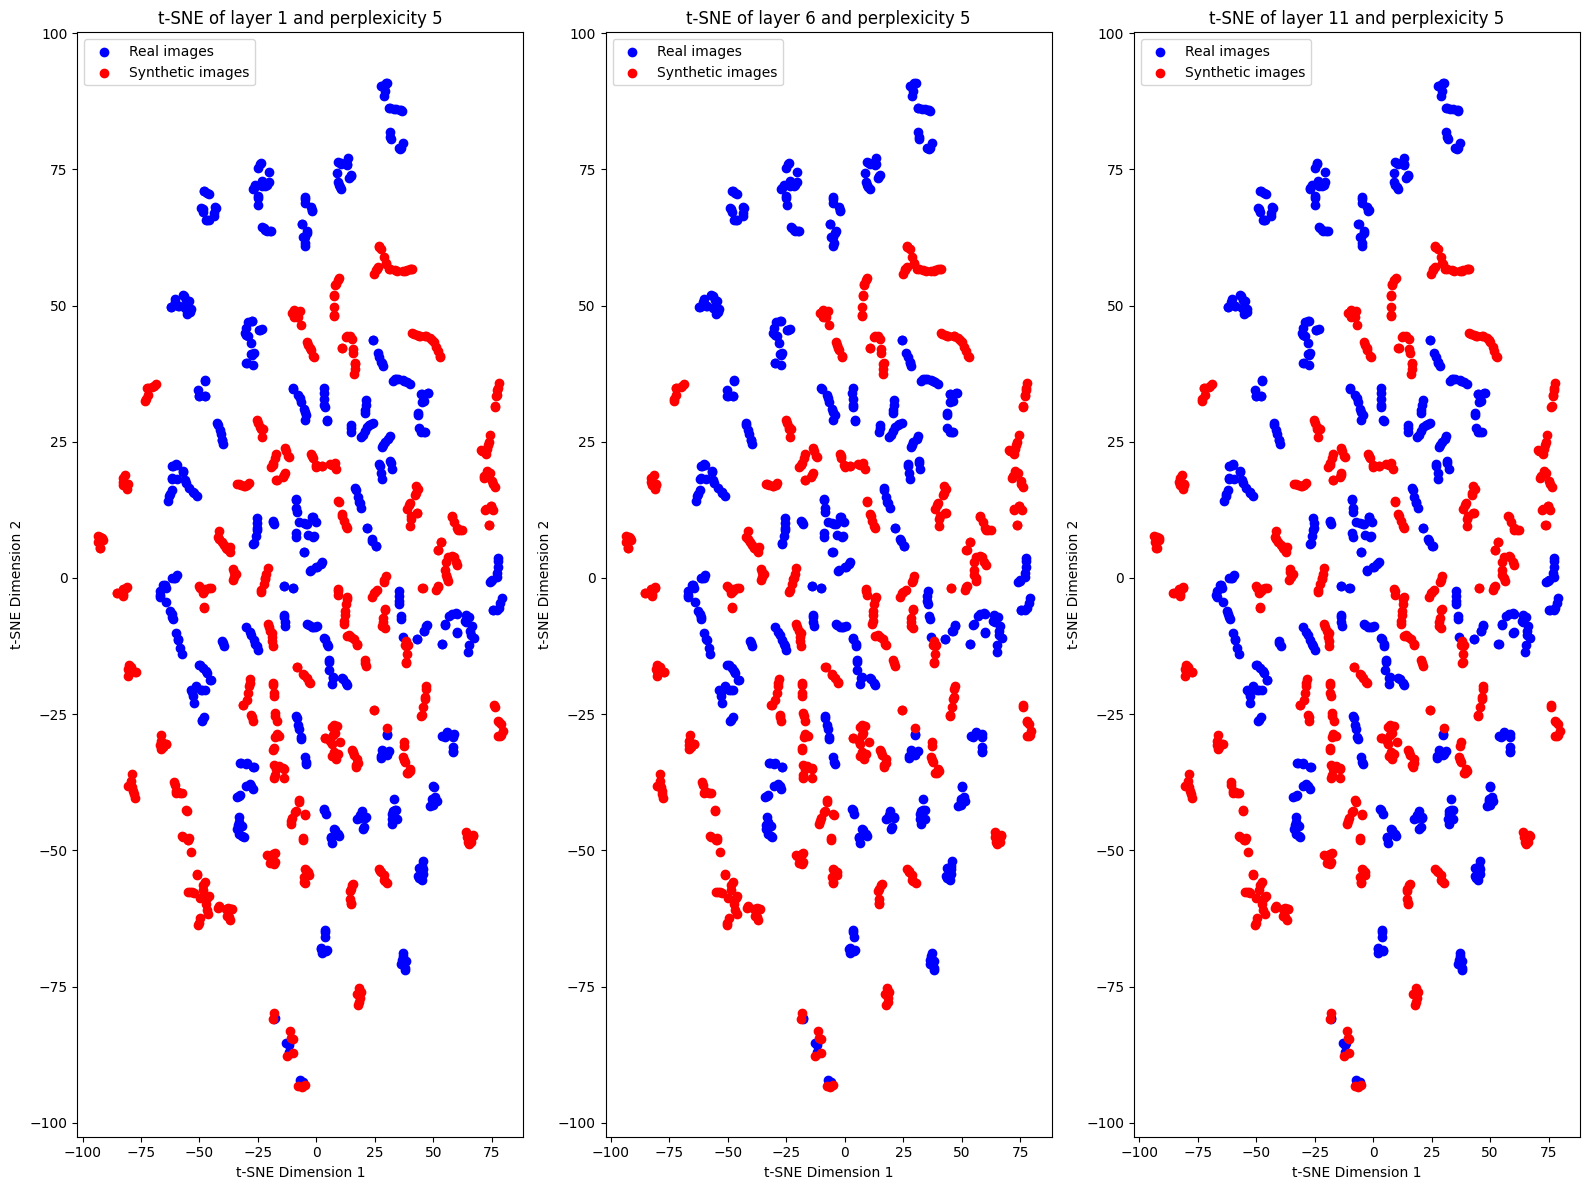

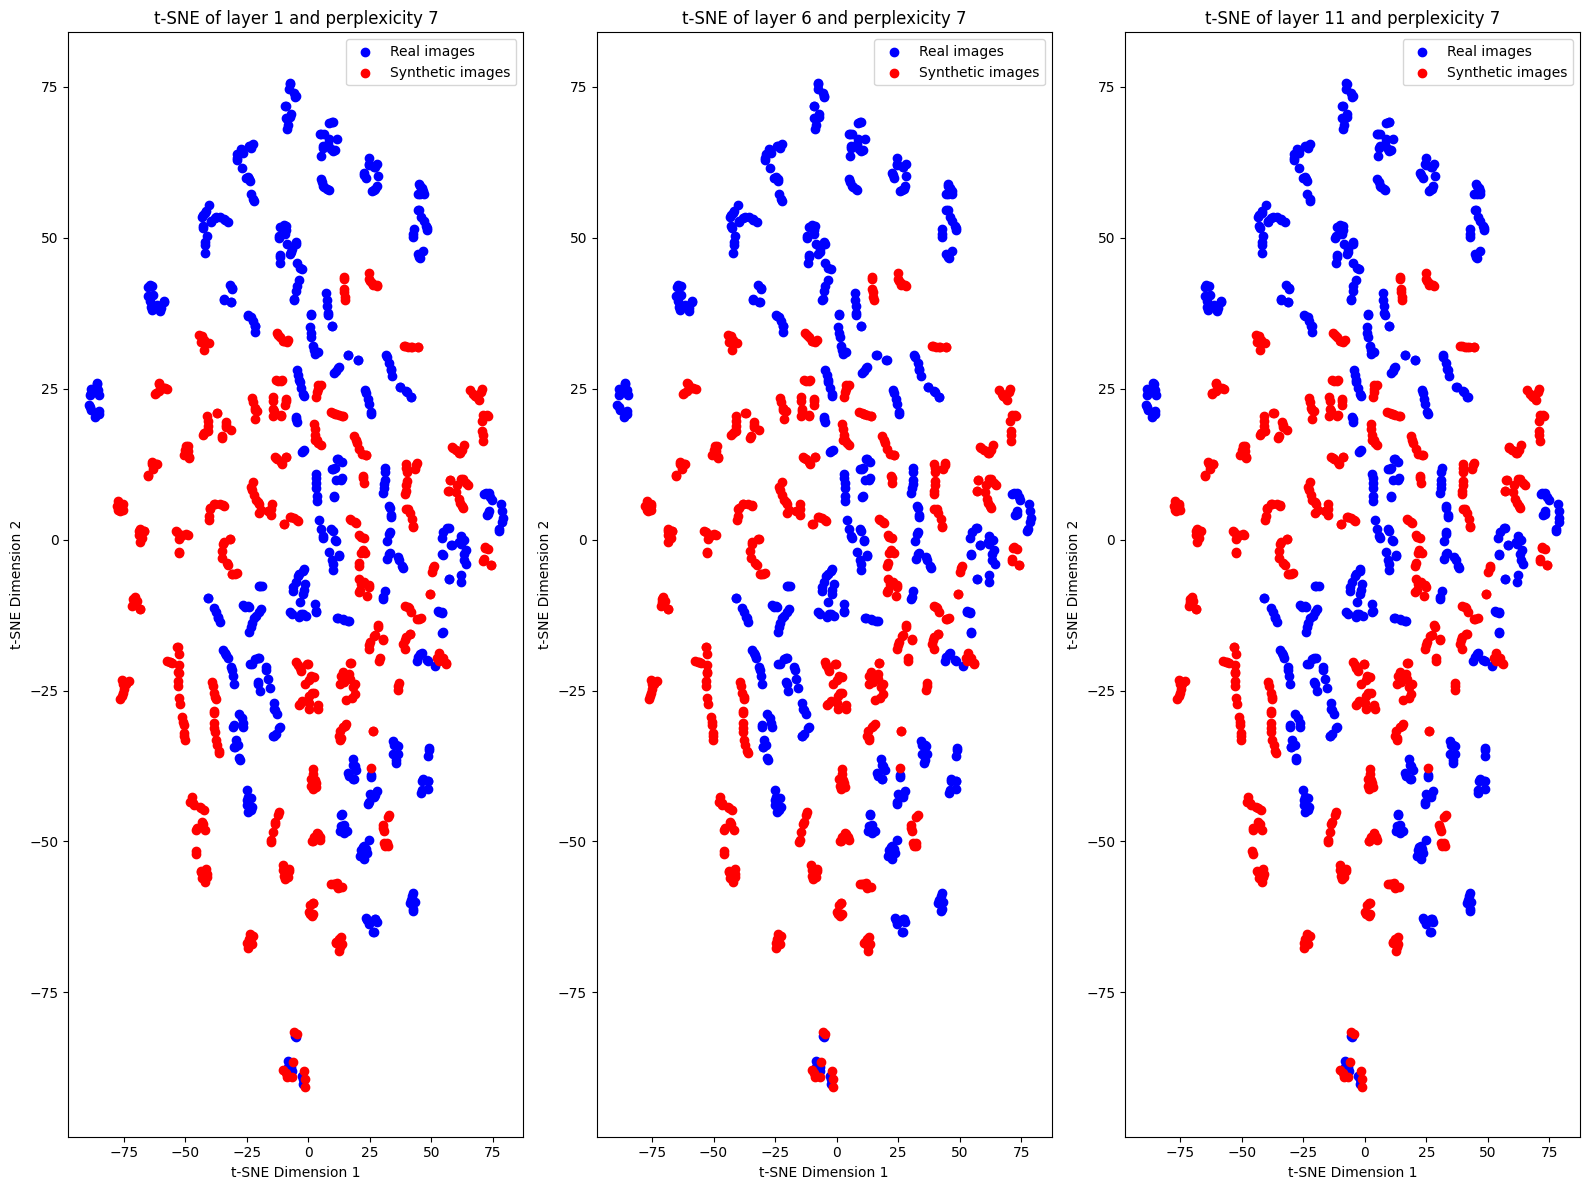

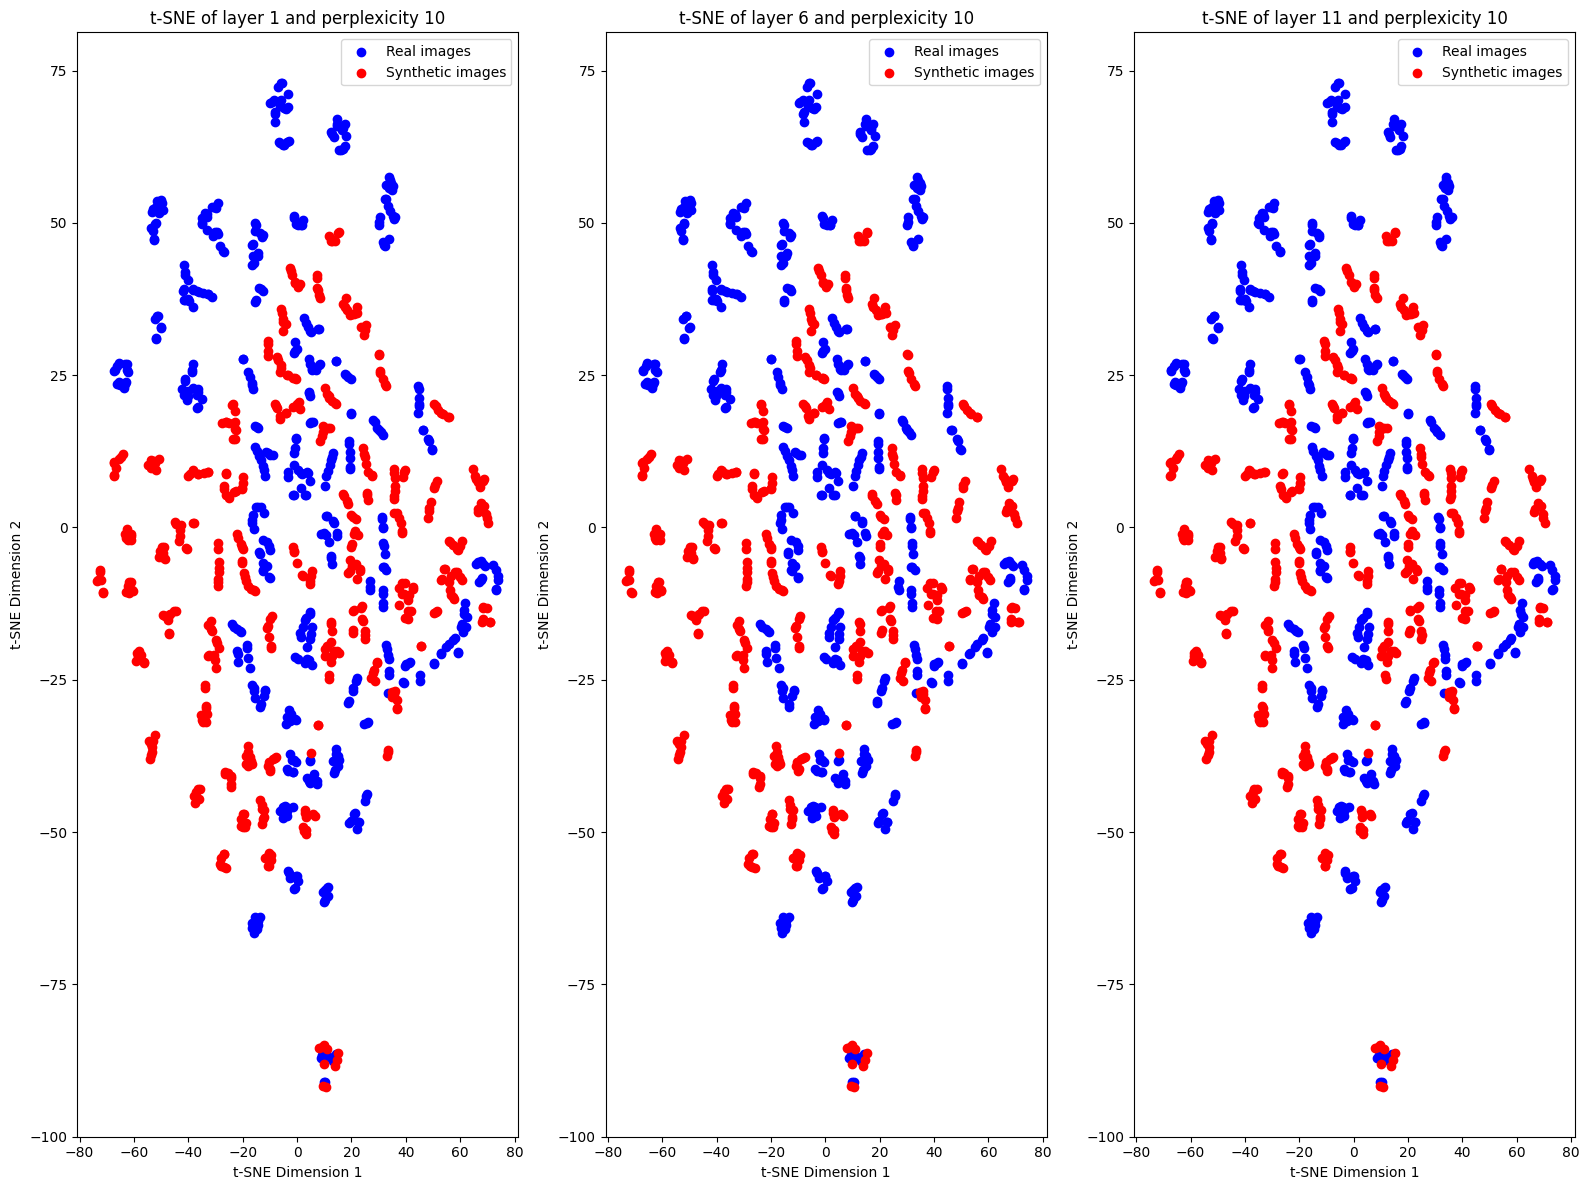

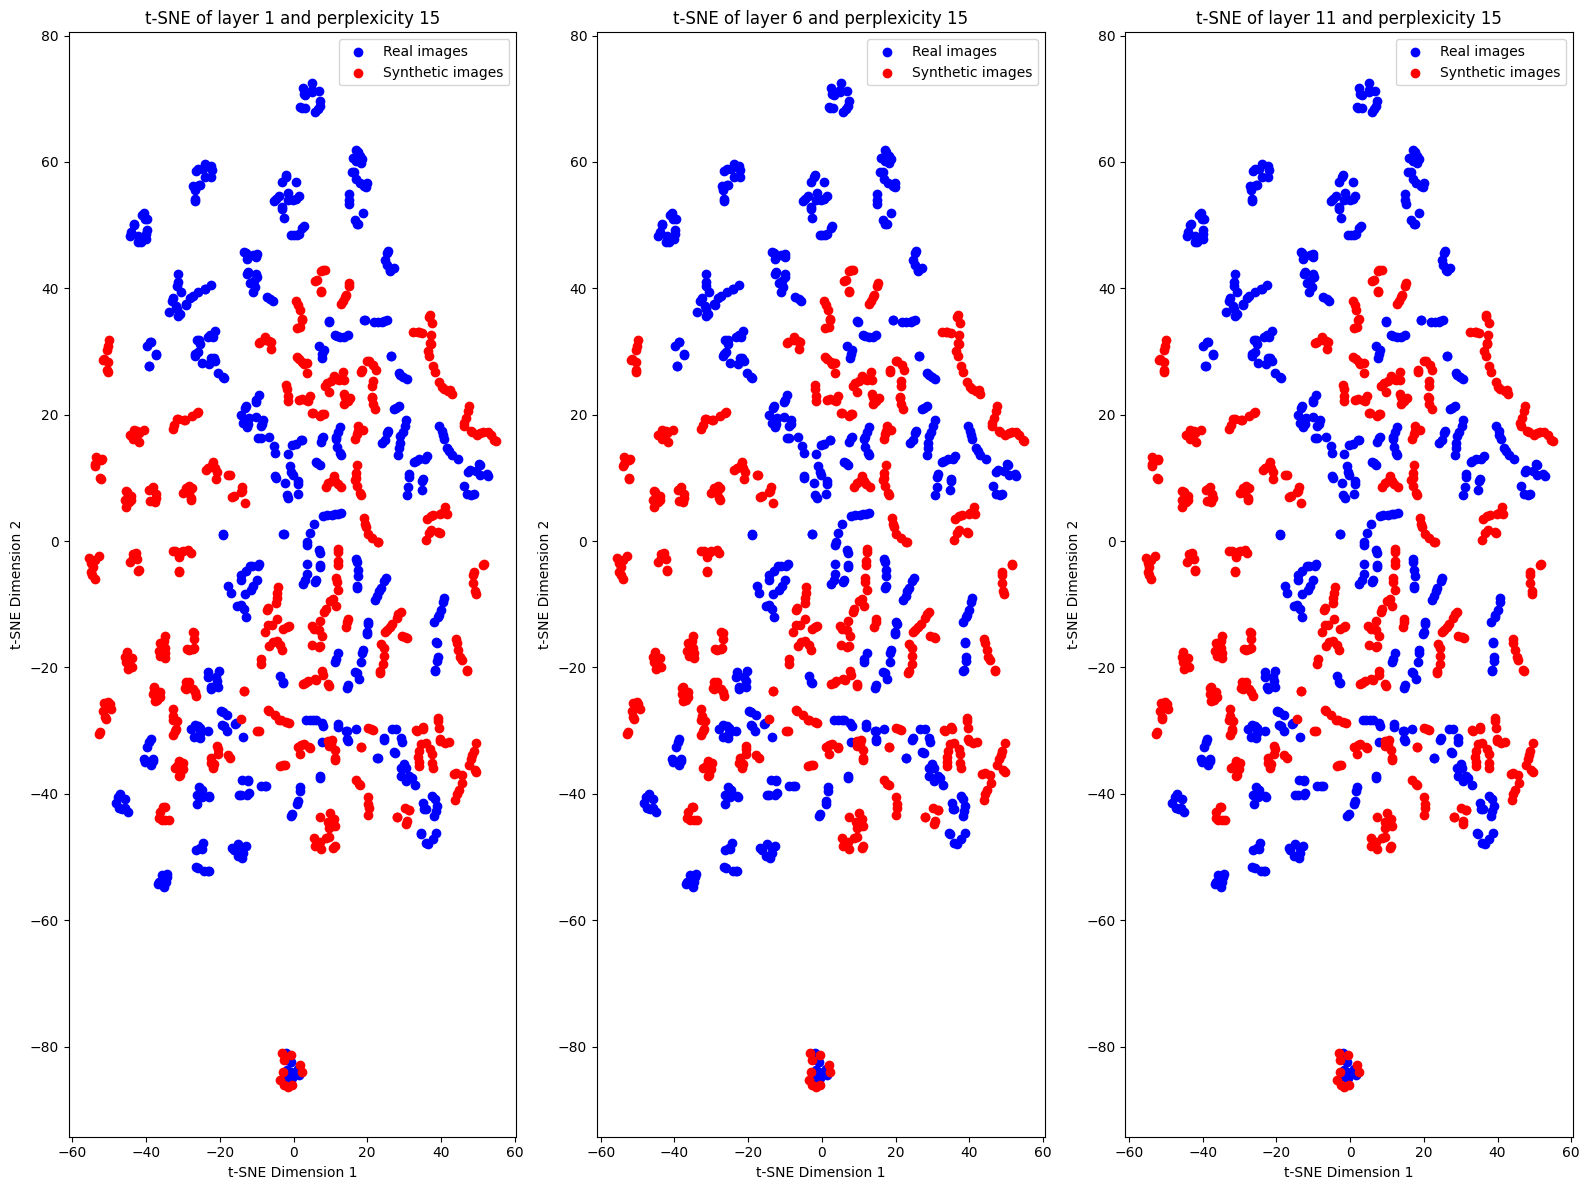

In [ ]:
# Dictionary to store intermediate outputs
intermediate_outputs = {}

# Function to capture layer outputs
def hook_fn(module, input, output):
    intermediate_outputs["layer"] = output.detach()

def extract_intermediate_features(model, inputs, device="cuda"):
    """Extract and flatten intermediate features from a specified layer."""
    features = []
    model.to(device)
    # Split into batches of size 16
    inputs = torch.split(inputs, 16)
    for batch in inputs:
        batch = batch.to(device)
        with torch.no_grad():
            _ = model.encode_image(batch)  # Use encode_image to process only images
        # Flatten the intermediate layer outputs
        flattened_output = intermediate_outputs["layer"].contiguous().view(intermediate_outputs["layer"].size(0), -1)
        features.append(flattened_output.cpu())
    return torch.cat(features, dim=0)  # Combine all outputs


layers = [0,5,10]
ps = [5,7,10,15]

for p in ps:
    print("p=",p)
    fig, axes = plt.subplots(1, 3, figsize=(16, 12))

    for idx,layer in enumerate(layers):
        print("layer",layer)

        # Register a hook on the desired layer
        target_layer = model.visual.transformer.resblocks[layer]  # layer varying
        hook_handle = target_layer.register_forward_hook(hook_fn)

        # Extract intermediate features
        real_intermediate_features = extract_intermediate_features(model, real_image_inputs, device=device)
        fake_intermediate_features = extract_intermediate_features(model, fake_image_inputs, device=device)

        # Convert to NumPy for t-SNE
        real_intermediate_features_np = real_intermediate_features.numpy()
        fake_intermediate_features_np = fake_intermediate_features.numpy()

        # Concatenate real and fake features
        intermediate_features_np = np.concatenate([real_intermediate_features_np, fake_intermediate_features_np], axis=0)

        # Apply t-SNE
        tsne = TSNE(n_components=2, perplexity=p, random_state=42)
        tsne_results = tsne.fit_transform(intermediate_features_np)

        # Plot the t-SNE results in a subplo

        axes[idx].scatter(tsne_results[:len(real_intermediate_features), 0],
                  tsne_results[:len(real_intermediate_features), 1], color="blue", label="Real images")
        axes[idx].scatter(tsne_results[len(real_intermediate_features):, 0],
                  tsne_results[len(real_intermediate_features):, 1], color="red", label="Synthetic images")

        axes[idx].legend()
        axes[idx].set_title(f"t-SNE of layer {layer + 1} and perplexicity {p}")
        axes[idx].set_xlabel("t-SNE Dimension 1")
        axes[idx].set_ylabel("t-SNE Dimension 2")

        # Remove the hook after you're done
        hook_handle.remove()

          # Adjust layout to prevent overlap
        plt.tight_layout()

    fig.savefig(f'content/MyDrive/Colab Notebooks/Datasets/tSNE-L{layer}-p{p}.png')


Perplexity = 30
start tsne
end tsne


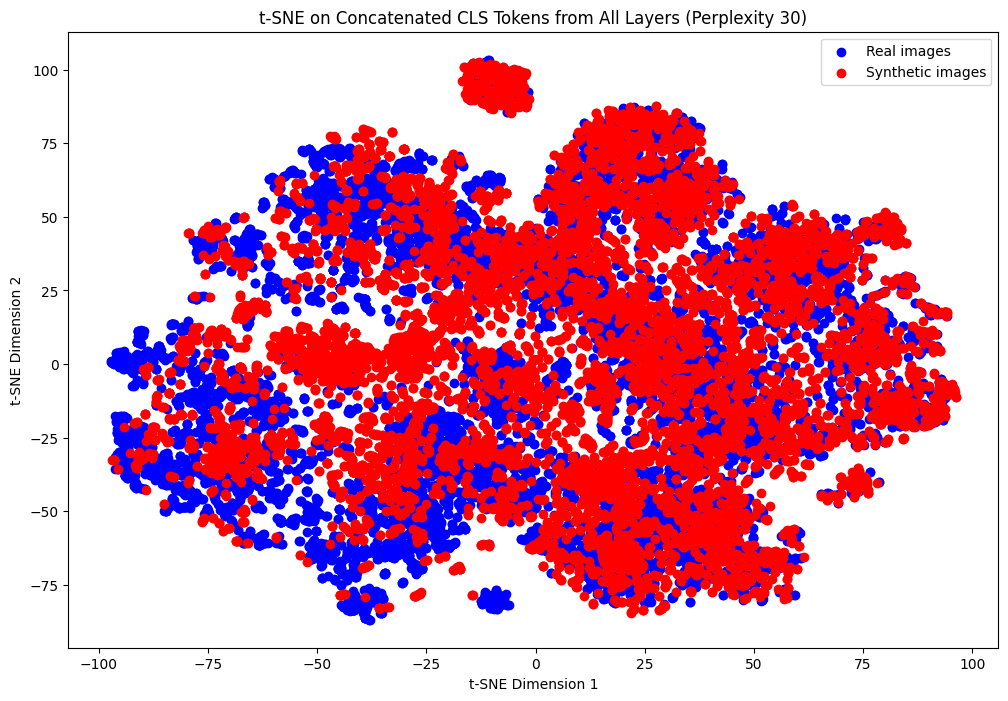

In [ ]:
# Dictionary to store CLS tokens
cls_tokens = {}

# Function to capture CLS tokens dynamically
def cls_hook_fn(layer_index):
    def hook_fn(module, input, output):
        cls_tokens[f"layer_{layer_index}"] = output[:, 0, :].detach()  # Extract CLS token
    return hook_fn

def extract_concatenated_cls_tokens_all(model, inputs, num_blocks, device="cuda"):
    """Extract concatenated CLS tokens from all Transformer blocks."""
    concatenated_features = []
    model.to(device)
    # Split inputs into batches of size 16
    inputs = torch.split(inputs, 16)
    for batch in inputs:
        batch = batch.to(device)
        with torch.no_grad():
            _ = model.encode_image(batch)  # Process images through the model
        # Concatenate CLS tokens from all registered layers
        layer_features = [cls_tokens[f"layer_{i}"].cpu() for i in range(num_blocks)]
        concatenated_features.append(torch.cat(layer_features, dim=-1))  # Concatenate along feature dimension
    return torch.cat(concatenated_features, dim=0)  # Combine batches

# Number of Transformer blocks in CLIP
num_blocks = len(model.visual.transformer.resblocks)

# Register hooks for all blocks dynamically
hooks = []
for i in range(num_blocks):
    target_layer = model.visual.transformer.resblocks[i]
    hooks.append(target_layer.register_forward_hook(cls_hook_fn(i)))

# Perplexities for t-SNE
ps = [30] #, 7, 10, 15]

for p in ps:
    print("Perplexity =", p)
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))

    # Extract concatenated CLS tokens
    real_features = extract_concatenated_cls_tokens_all(model, real_image_inputs, num_blocks, device=device)
    fake_features = extract_concatenated_cls_tokens_all(model, fake_image_inputs, num_blocks, device=device)

    # Convert to NumPy for t-SNE
    real_features_np = real_features.numpy()
    fake_features_np = fake_features.numpy()

    # Concatenate real and fake features
    all_features_np = np.concatenate([real_features_np, fake_features_np], axis=0)

    # Apply t-SNE
    print("start tsne")
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    tsne_results = tsne.fit_transform(all_features_np)
    print("end tsne")

    # Plot the t-SNE results
    plt.scatter(tsne_results[:len(real_features), 0], tsne_results[:len(real_features), 1],
                color="blue", label="Real images")
    plt.scatter(tsne_results[len(real_features):, 0], tsne_results[len(real_features):, 1],
                color="red", label="Synthetic images")

    plt.legend()
    plt.title(f"t-SNE on Concatenated CLS Tokens from All Layers (Perplexity {p})")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")

    # Save the plot
    plt.savefig(f'content/MyDrive/Colab Notebooks/Datasets/tSNE-Concatenated-All-CLS-p{p}.png')

# Remove hooks after processing
for hook in hooks:
    hook.remove()
